In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


In [14]:
df = pd.read_excel(r"C:\Users\gigan\Downloads\student_academic_dataset.xlsx")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Timestamp                       500 non-null    datetime64[ns]
 1   Student Roll Number / ID        500 non-null    object        
 2   Gender                          500 non-null    object        
 3   Semester 1 Subjects Passed      500 non-null    int64         
 4   Semester 1 Subjects Failed      500 non-null    int64         
 5   Semester 2 Subjects Passed      500 non-null    int64         
 6   Semester 2 Subjects Failed      500 non-null    int64         
 7   Average Attendance Percentage   500 non-null    int64         
 8   Assignment Submission Rate (%)  500 non-null    int64         
 9   Total Backlogs                  500 non-null    int64         
 10  Semester 3 overall result       500 non-null    object        
dtypes: dat

In [16]:
df = df.drop(columns=["Timestamp", "Student Roll Number / ID"])


In [17]:
le_gender = LabelEncoder()
df["Gender"] = le_gender.fit_transform(df["Gender"])

# Encode target variable
le_target = LabelEncoder()
df["Semester 3 overall result"] = le_target.fit_transform(df["Semester 3 overall result"])

In [18]:
X = df.drop("Semester 3 overall result", axis=1)
y = df["Semester 3 overall result"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [20]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [21]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.94

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92        37
           1       0.97      0.94      0.95        63

    accuracy                           0.94       100
   macro avg       0.93      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100


Confusion Matrix:
 [[35  2]
 [ 4 59]]


In [22]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
joblib.dump(model, "student_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully")

Model and scaler saved successfully


In [24]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

model = joblib.load("student_model.pkl")
scaler = joblib.load("scaler.pkl")

st.title("Student Pass / Fail Predictor")

gender = st.selectbox("Gender", ["Male", "Female"])

sem1_pass = st.number_input("Semester 1 Subjects Passed", 0, 11)
sem1_fail = st.number_input("Semester 1 Subjects Failed", 0, 11)

sem2_pass = st.number_input("Semester 2 Subjects Passed", 0, 11)
sem2_fail = st.number_input("Semester 2 Subjects Failed", 0, 11)

attendance = st.selectbox(
    "Average Attendance Percentage",
    ["Below 50%", "50%-65%", "66%-75%", "76%-85%", "Above 85%"]
)

assignment_rate = st.slider(
    "Assignment Submission Rate (%)",
    0, 100
)

total_backlogs = st.number_input("Total Backlogs", 0, 10)

if st.button("Predict"):

    gender_map = {"Female": 0, "Male": 1}

    attendance_map = {
        "Below 50%": 0,
        "50%-65%": 1,
        "66%-75%": 2,
        "76%-85%": 3,
        "Above 85%": 4
    }

    input_df = pd.DataFrame([{
        "Gender": gender_map[gender],
        "Semester 1 Subjects Passed": sem1_pass,
        "Semester 1 Subjects Failed": sem1_fail,
        "Semester 2 Subjects Passed": sem2_pass,
        "Semester 2 Subjects Failed": sem2_fail,
        "Average Attendance Percentage": attendance_map[attendance],
        "Assignment Submission Rate (%)": assignment_rate,
        "Total Backlogs": total_backlogs
    }])

    input_scaled = scaler.transform(input_df)

    prediction = model.predict(input_scaled)[0]

    if prediction == 1:
        st.success("Student likely to PASS")
    else:
        st.error("Student likely to FAIL")


Overwriting app.py


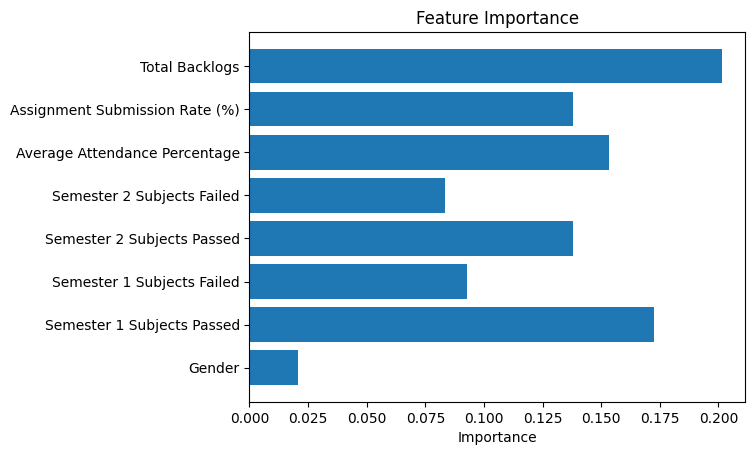

In [25]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X.columns

plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()
